In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from tools.preprocess import load_datasets, preprocess_hepatitis_datasets
from tools.distance import ManhattanDistance, EuclideanDistance
from tools.voting import MajorityClassVote, InverseDistanceWeightedVote, ShepardsWorkVote
from tools.knn import KNNClassifier, cross_validate_knn
import itertools
from functools import partial
import logging

logging.basicConfig(level=logging.ERROR, format="%(levelname)s - %(message)s")
logger = logging.getLogger()

In [2]:
train_dfs = load_datasets("datasetsCBR/hepatitis/hepatitis.fold.*.train.arff")
test_dfs = load_datasets("datasetsCBR/hepatitis/hepatitis.fold.*.test.arff")

print(f"\nNumber of training dataframes: {len(train_dfs)}")
print(f"Number of test dataframes: {len(test_dfs)}")
print()
train_dfs[0].head()


Number of training dataframes: 10
Number of test dataframes: 10



,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,50.0,b'female',b'no',b'no',b'yes',b'no',b'no',b'no',b'no',b'no',b'no',b'no',b'no',0.9,135.0,42.0,3.5,NaN,b'no',b'LIVE'
1,45.0,b'male',b'no',b'no',b'yes',b'yes',b'no',b'yes',b'no',b'yes',b'no',b'no',b'no',1.0,85.0,75.0,NaN,NaN,b'no',b'LIVE'
2,54.0,b'female',b'no',b'no',b'yes',b'yes',b'no',b'?',b'?',b'yes',b'no',b'yes',b'no',3.9,120.0,28.0,3.5,43.0,b'yes',b'DIE'
3,35.0,b'female',b'no',b'no',b'yes',b'no',b'no',b'?',b'?',b'yes',b'yes',b'yes',b'no',1.5,138.0,58.0,2.6,NaN,b'yes',b'DIE'
4,24.0,b'female',b'no',b'no',b'yes',b'no',b'no',b'yes',b'no',b'no',b'no',b'no',b'no',1.0,NaN,34.0,4.1,NaN,b'yes',b'LIVE'


In [3]:
pd.concat(train_dfs + test_dfs).isnull().sum()

AGE                  0
SEX                  0
STEROID              0
ANTIVIRALS           0
FATIGUE              0
MALAISE              0
ANOREXIA             0
LIVER_BIG            0
LIVER_FIRM           0
SPLEEN_PALPABLE      0
SPIDERS              0
ASCITES              0
VARICES              0
BILIRUBIN           60
ALK_PHOSPHATE      290
SGOT                40
ALBUMIN            160
PROTIME            670
HISTOLOGY            0
Class                0
dtype: int64

In [4]:
for df in train_dfs + test_dfs:
    preprocess_hepatitis_datasets(df)

train_dfs[0].head()

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,29,0,1,0,2,1,1,1,1,1,1,1,1,-0.437746,0.701810,-0.471396,-0.555871,-0.063718,0,1
1,24,1,1,0,2,2,1,2,1,2,1,1,1,-0.345659,-0.348394,-0.090769,0.246537,-0.063718,0,1
2,33,0,1,0,2,2,1,0,0,2,1,2,1,2.324858,0.386749,-0.632875,-0.555871,-0.965572,1,0
3,14,0,1,0,2,1,1,0,0,2,2,2,1,0.114775,0.764823,-0.286850,-2.000206,-0.063718,1,0
4,4,0,1,0,2,1,1,2,1,1,1,1,1,-0.345659,-0.348394,-0.563670,0.407019,-0.063718,1,1


In [5]:
pd.concat(train_dfs + test_dfs).isnull().sum()

AGE                0
SEX                0
STEROID            0
ANTIVIRALS         0
FATIGUE            0
MALAISE            0
ANOREXIA           0
LIVER_BIG          0
LIVER_FIRM         0
SPLEEN_PALPABLE    0
SPIDERS            0
ASCITES            0
VARICES            0
BILIRUBIN          0
ALK_PHOSPHATE      0
SGOT               0
ALBUMIN            0
PROTIME            0
HISTOLOGY          0
Class              0
dtype: int64

In [6]:
k_values = [1, 3, 5, 7]
distance_funcs = [ManhattanDistance(), EuclideanDistance()]
voting_funcs = [MajorityClassVote(), InverseDistanceWeightedVote(), ShepardsWorkVote()]

results = pd.DataFrame(
    columns=[
        "k",
        "distance_func",
        "voting_func",
        "f1_mean",
        "f1_std",
    ]
)
for k, distance_func, voting_func in itertools.product(
    k_values, distance_funcs, voting_funcs
):
    knn = KNNClassifier(
        k=k,
        distance_func=distance_func,
        voting_func=voting_func,
        weights=np.ones(len(train_dfs[0].columns) - 1),
    )
    scores = cross_validate_knn(
        knn,
        train_dfs,
        test_dfs,
        target_col="Class",
        score_func=partial(f1_score, average="weighted"),
    )
    results.loc[len(results)] = [
        k,
        distance_func.__class__.__name__,
        voting_func.__class__.__name__,
        scores.mean(),
        scores.std(),
    ]

results.sort_values(by="f1_mean", ascending=False)

,k,distance_func,voting_func,f1_mean,f1_std
19,7,ManhattanDistance,InverseDistanceWeightedVote,0.820619,0.098466
16,5,EuclideanDistance,InverseDistanceWeightedVote,0.807604,0.065592
13,5,ManhattanDistance,InverseDistanceWeightedVote,0.805798,0.095203
23,7,EuclideanDistance,ShepardsWorkVote,0.801222,0.070891
22,7,EuclideanDistance,InverseDistanceWeightedVote,0.801222,0.070891
17,5,EuclideanDistance,ShepardsWorkVote,0.794869,0.070540
20,7,ManhattanDistance,ShepardsWorkVote,0.791731,0.082719
10,3,EuclideanDistance,InverseDistanceWeightedVote,0.789908,0.066947
11,3,EuclideanDistance,ShepardsWorkVote,0.789908,0.066947
3,1,EuclideanDistance,MajorityClassVote,0.785027,0.096029


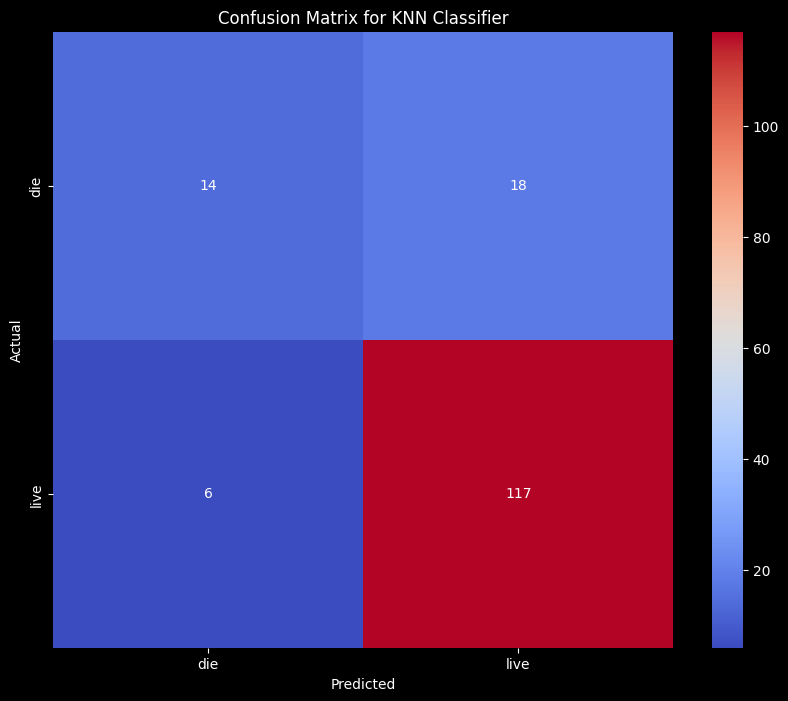

In [7]:
knn = KNNClassifier(
    k=7,
    distance_func=ManhattanDistance(),
    voting_func=InverseDistanceWeightedVote(),
    weights=np.ones(len(train_dfs[0].columns) - 1),
)
scores = cross_validate_knn(
        knn,
        train_dfs,
        test_dfs,
    target_col="Class",
    score_func=partial(confusion_matrix),
)
sum_scores = scores.sum(axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(sum_scores, annot=True, fmt="d", cmap="coolwarm")
plt.title("Confusion Matrix for KNN Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=["die", "live"])
plt.yticks(ticks=[0.5, 1.5], labels=["die", "live"])
plt.show()


# Pre-Analysis

In [8]:
preds = []
actuals = []

for train_df, test_df in zip(train_dfs, test_dfs):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(train_df.drop("Class", axis=1), train_df["Class"])
    preds.extend(decision_tree.predict(test_df.drop("Class", axis=1)))
    actuals.extend(test_df["Class"])

print(classification_report(actuals, preds))

              precision    recall  f1-score   support

           0       0.48      0.31      0.38        32
           1       0.84      0.91      0.87       123

    accuracy                           0.79       155
   macro avg       0.66      0.61      0.62       155
weighted avg       0.76      0.79      0.77       155



It looks like a decision tree is not able to learn the data well, possibly because the 0th class is a minority class.

In [9]:
feature_importances = pd.DataFrame(
    {
        "feature": train_dfs[0].drop("Class", axis=1).columns,
        "importance": decision_tree.feature_importances_,
        "index": range(len(decision_tree.feature_importances_)),
    }
)
top_5_features = feature_importances.sort_values("importance", ascending=False).head(5)
print("Top 5 features:")
top_5_features

Top 5 features:


,feature,importance,index
16,ALBUMIN,0.259046,16
10,SPIDERS,0.124641,10
14,ALK_PHOSPHATE,0.108528,14
0,AGE,0.101595,0
13,BILIRUBIN,0.077379,13


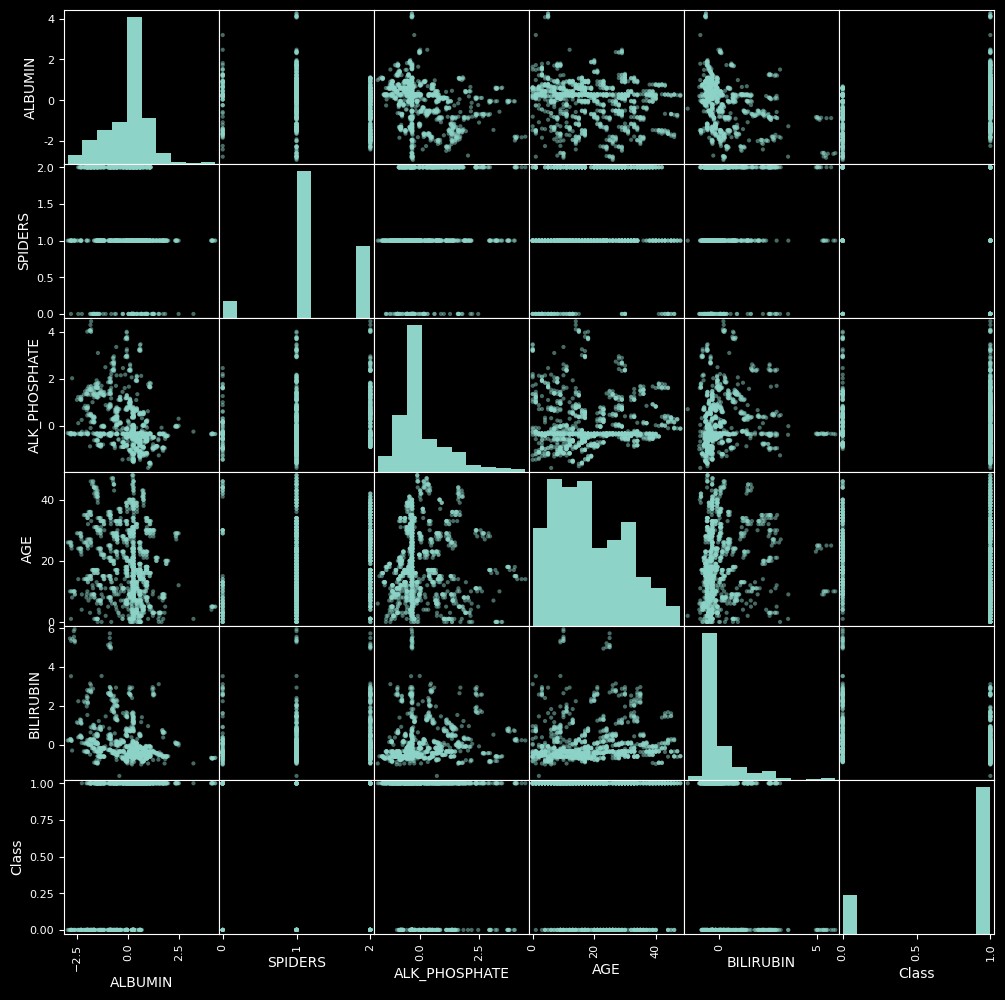

In [10]:
pd.plotting.scatter_matrix(
    pd.concat(train_dfs + test_dfs)[top_5_features.feature.values.tolist() + ["Class"]],
    figsize=(12, 12),
)
plt.show()

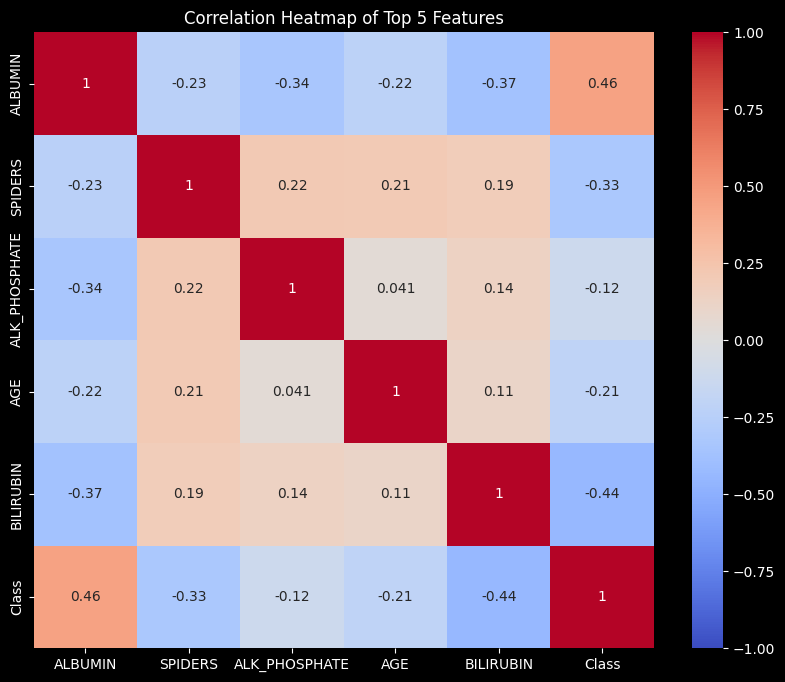

In [11]:
import seaborn as sns

top_5_features_and_class = top_5_features["feature"].tolist() + ["Class"]
corr_matrix = pd.concat(train_dfs + test_dfs)[top_5_features_and_class].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Top 5 Features")
plt.show()